## FIT3162 Group MCS2 Model Training

#### Import PyTorch and related stuff

In [1]:
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from sklearn.metrics import classification_report
from PIL import ImageFile
from math import modf
from CustomDataset import CustomDataset


import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import seaborn as sn
import pandas as pd
import numpy as np

import torch
import time
import random
import os

#### Select and print the device (CPU or GPU) we are using for the training process.

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


#### Initialize augmentation, batch size value for dataset

In [3]:
# set training parameters
BATCH_SIZE = 15 ## Change batch size as required, if when training there is not enough memory, decrease it,
                            ## Else try to increase it and push it, bigger batch size, less epoch may be required to reach
                            ## desired accuracy/diminishing return point
PROCESSES = 8 ## Maximum is how much logical processors.
EPOCHS = 10  

# Initialize transformation
transform = transforms.Compose([
    # resize
    transforms.Resize(256),
    # center_crop
    transforms.CenterCrop(224),
    transforms.GaussianBlur(3, 1),
    transforms.RandomGrayscale(0.1),
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomVerticalFlip(0.2),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.25)),
    transforms.RandomApply(transforms=[transforms.RandomAffine(degrees=(-45, 45), translate=(0.1, 0.3),
                                                               scale=(0.75, 0.95))], p=0.6),
    transforms.Normalize(mean=[0.4704, 0.4565, 0.4425], std=[0.3045, 0.2898, 0.2999])
])

transform_test = transforms.Compose([
    # resize
    transforms.Resize(256),
    # center_crop
    transforms.CenterCrop(224),
    transforms.GaussianBlur(3, 1),  # Remove noise
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4704, 0.4565, 0.4425], std=[0.3045, 0.2898, 0.2999])
])

transform_unnormalize = transforms.Compose([
    transforms.Normalize(mean=[-0.4704 / 0.3045, -0.4565 / 0.2898, -0.4425 / 0.2999],
                         std=[1.0 / 0.3045, 1.0 / 0.2898, 1.0 / 0.2999])
])

### Get Dataset
#### Original dataset -> get sub label for all images -> (magic bodge: built in function to go and get labels, which corresponds correctly)

#### -> Split using sklearn

In [4]:
# timing dataset preprocessing in case it takes too long in the future when dataset gets bloated
start = time.time()
print(f'Loading main dataset... ', end="")

dataset = CustomDataset(root="./dataset", transform=transform)
dataset_test = CustomDataset(root="./dataset", transform=transform_test)
# Get sub classes in each category
classes_sport = dataset.find_classes(dataset.root+"/sport")
classes_non_sport = dataset.find_classes(dataset.root+"/non sport")
# Combined classes
both_combined =  classes_non_sport[0] + classes_sport[0]
# Bodge to use built in function
IMG_EXTENSIONS = (".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp")
# Create labels for built in func

non_sport_dict = {}
for i in range(len(classes_non_sport[0])):
    non_sport_dict[classes_non_sport[0][i]] = i

sport_dict = {}
for i in range(len(classes_non_sport[0]), len(classes_sport[0])+len(classes_non_sport[0])):
    sport_dict[classes_sport[0][i-len(classes_non_sport[0])]] = i

print("Done\n")
    
# Use build in function to get us labels, however it is inefficient because
# it also recreates a whole new dataset variable...
sports_temp = dataset.make_dataset(dataset.root+"/sport", sport_dict, IMG_EXTENSIONS, None)
non_sports_temp = dataset.make_dataset(dataset.root+"/non sport", non_sport_dict, IMG_EXTENSIONS, None)
# Retrieve the sub label 
# Must be non_sports first! A-Z!
non_sports_label = [s[1] for s in non_sports_temp]
sports_label = [s[1] for s in sports_temp]
# Combine and add as attribute
combined = non_sports_label + sports_label
dataset.sub_labels = combined
dataset_test.sub_labels = combined

Loading main dataset... Done



In [5]:
print("Splitting into Train, Validation and Test sets... ", end="")
# Split into train, test and validation sets
train_idx, test_idx, train_labels, test_labels = train_test_split(
    np.arange(len(dataset.sub_labels)), dataset.sub_labels, test_size=0.2, random_state=42, shuffle=True, stratify=dataset.sub_labels)
test_idx, valid_idx, test_labels, val_label = train_test_split(test_idx, test_labels, test_size=0.5, random_state=42, shuffle=True, stratify=test_labels)

# Create the sets
train_data = Subset(dataset, train_idx)
test_data = Subset(dataset_test, test_idx)
val_data = Subset(dataset_test, valid_idx)

train_size = len(train_data)
val_size = len(val_data)
test_size = len(test_data)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=PROCESSES , shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=PROCESSES , shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, num_workers=PROCESSES , shuffle=True, pin_memory=True)

runtime = time.time() - start
seconds, minutes = modf(runtime/60)
seconds *= 60

print(f'Done\n\nTrain set      : {train_size} images')
print(f'Validation set : {val_size} images')
print(f'Test set       : {val_size} images\n')
print(f'Total time taken for dataset: {minutes:.0f} min {seconds:.2f} sec\n-----------------------------\n')

Splitting into Train, Validation and Test sets... Done

Train set      : 10160 images
Validation set : 1270 images
Test set       : 1270 images

Total time taken for dataset: 0 min 0.20 sec
-----------------------------



In [6]:
both_combined

['Cello (265)',
 'Dab (90)',
 'Dog chasing ball (330) ambiguous',
 'Driving (245)',
 'Guitar (285)',
 'Harp (225)',
 'Holding ball (265) ambiguous',
 'Holding something (245) ambiguous',
 'Jumping (270) ambiguous',
 'Leisure sea activity (320)',
 'Pedestrian (260)',
 'Plane flying (265)',
 'Queue (240)',
 'Random pic with sky view (60)',
 'Reading (195)',
 'Riding motorcycle (110)',
 'Ship with sea (235)',
 'Sleeping (400)',
 'Standing (300)',
 'Standing beside bicycle (250) ambiguous',
 'Using computer (305)',
 'Violin (270)',
 'Waving (80)',
 'Badminton (645)',
 'Baseball (375)',
 'Basketball (465)',
 'Boxing (245)',
 'Cycling (490)',
 'Fencing (350)',
 'Football (340)',
 'Golf (425)',
 'Race walking (230) ambiguous',
 'Sky diving (340)',
 'Squash (355)',
 'Swimming (420)',
 'Table tennis (460)',
 'Tennis (500)',
 'Track and field (745)',
 'Volleyball (405)',
 'Weightlifting (400)']

In [7]:
# Count each class in original
count_original = {classname: 0 for classname in range(len(both_combined))}
for i in range(len(dataset)):
    label = dataset.sub_labels[i]
    count_original[label] += 1
count_original

{0: 265,
 1: 90,
 2: 330,
 3: 245,
 4: 285,
 5: 225,
 6: 265,
 7: 245,
 8: 270,
 9: 320,
 10: 260,
 11: 265,
 12: 240,
 13: 60,
 14: 195,
 15: 110,
 16: 235,
 17: 400,
 18: 300,
 19: 250,
 20: 305,
 21: 270,
 22: 80,
 23: 645,
 24: 375,
 25: 465,
 26: 245,
 27: 490,
 28: 350,
 29: 340,
 30: 425,
 31: 230,
 32: 340,
 33: 355,
 34: 420,
 35: 460,
 36: 500,
 37: 745,
 38: 405,
 39: 400}

In [8]:
# Count each class in train
count_train = {classname: 0 for classname in range(len(both_combined))}
for each in train_idx:
    label = dataset.sub_labels[each]
    count_train[label] += 1
count_train

{0: 212,
 1: 72,
 2: 264,
 3: 196,
 4: 228,
 5: 180,
 6: 212,
 7: 196,
 8: 216,
 9: 256,
 10: 208,
 11: 212,
 12: 192,
 13: 48,
 14: 156,
 15: 88,
 16: 188,
 17: 320,
 18: 240,
 19: 200,
 20: 244,
 21: 216,
 22: 64,
 23: 516,
 24: 300,
 25: 372,
 26: 196,
 27: 392,
 28: 280,
 29: 272,
 30: 340,
 31: 184,
 32: 272,
 33: 284,
 34: 336,
 35: 368,
 36: 400,
 37: 596,
 38: 324,
 39: 320}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
D:\IDEs\Anaconda\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


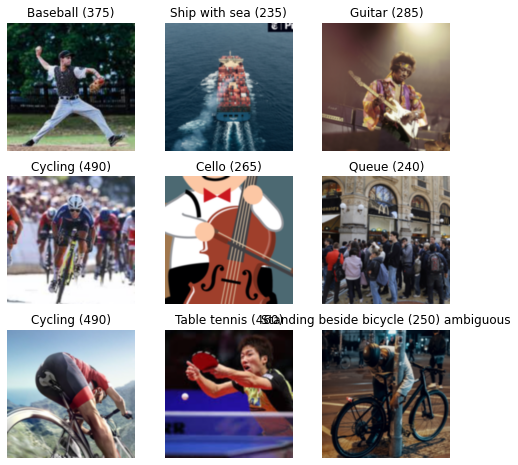

In [9]:
# Visualise image to double check we have correct sublabel
# We check validation set
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(val_size, size=(1,)).item()
    img, label = val_data[sample_idx]
    sublabel = val_label[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(both_combined[sublabel])
    plt.axis("off")
    img = transform_unnormalize(img)     # attempt to unnormalize...
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

#### Visualize data according to sports/non-sports

In [10]:
labels_map = ["Non Sports", "Sports"]

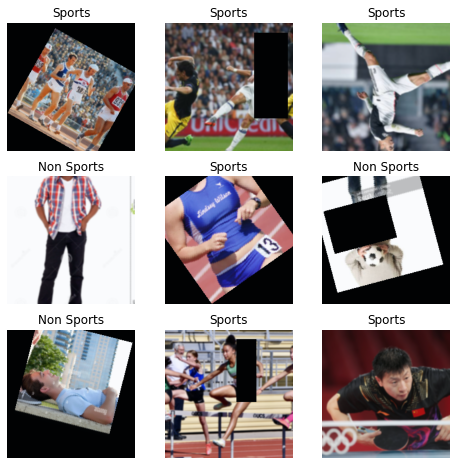

In [11]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(train_size, size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label["main_label"]])
    plt.axis("off")
    img = transform_unnormalize(img)     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [12]:
class MultiOutputModel(nn.Module):

    def __init__(self, n_main_classes, n_sub_classes):
        super().__init__()
        self.base_model = models.alexnet(weights='AlexNet_Weights.DEFAULT').features  # take the model without classifier
        self.pool = nn.AdaptiveAvgPool2d((6, 6))
        # create separate classifiers for our outputs
        self.main_label = models.alexnet(weights='AlexNet_Weights.DEFAULT').classifier
        self.main_label[6] = nn.Linear(in_features=4096, out_features=n_main_classes)
        self.sub_label = models.alexnet(weights='AlexNet_Weights.DEFAULT').classifier
        self.sub_label[6] = nn.Linear(in_features=4096, out_features=n_sub_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = self.pool(x)

        # reshape from [batch, channels, 1, 1] to [batch, channels] to put it into classifier
        x = torch.flatten(x, start_dim=1)

        return {
            'main_label': self.main_label(x),
            'sub_label': self.sub_label(x),
        }
    
    def get_loss(self, net_output, ground_truth):
        main_loss = F.cross_entropy(net_output['main_label'], ground_truth['main_label'])
        sub_loss = F.cross_entropy(net_output['sub_label'], ground_truth['sub_label'])
        loss = main_loss + sub_loss
        return loss, {'main_loss': main_loss, 'sub_loss': sub_loss}

# Load Model
model_ft = MultiOutputModel(2, len(both_combined))
model_ft = model_ft.to(device)

In [13]:
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8) # Multiply learning rate by 0.8 every 2 epoch

In [14]:
# Training information
TRAIN_STAT = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

In [15]:
def to_device_dict(obj, device):
    res = {}
    for k, v in obj.items():
      res[k] = v.to(device)
    return res

### Train model

In [16]:
# ImageFile.LOAD_TRUNCATED_IMAGES = True # Remove this and see if any error
print("Training model...")
start = time.time()

for epoch in range(EPOCHS):  # loop over the training set multiple times
    
    print(f'\n-----------------------------\n\nEPOCH: {epoch+1}/{EPOCHS}')
    print('Current lr: {0}'.format(optimizer.param_groups[0]['lr']))
    
    model_ft.train()
    
    # reset loss and correct values
    train_loss = val_loss = 0
    total_train_loss = total_val_loss = 0.0
    train_correct = val_correct = 0

    print('\nTraining...')
    
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]        
        inputs, labels = data[0].to(device), data[1]
        labels = to_device_dict(labels, device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # make prediction and calculate train loss
        outputs = model_ft(inputs)
        loss, losses_by_class = model_ft.get_loss(outputs, labels)
        
        # forward + backward + optimize
        loss.backward()
        optimizer.step()

        # keep track of loss and correct statistics
        train_loss += loss.item()
        total_train_loss += loss.item() 
        train_correct += (outputs["main_label"].argmax(1) == labels["main_label"]).float().sum().item()
        
        if i % 20 == 19:    # print every 20 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {train_loss / 20:.10f}')
            train_loss = 0.0
        
    print('\nValidating...')
    
    # turn off gradient tracking and computation
    with torch.no_grad():
        
        model_ft.eval()
        
        for i, data in enumerate(val_loader):
            # make predictions and calculate validation loss
            inputs, labels = data[0].to(device), data[1]
            labels = to_device_dict(labels, device)
            outputs = model_ft(inputs)
            loss, losses_by_class = model_ft.get_loss(outputs, labels)
            
            # keep track of loss and correct statistics
            val_loss += loss.item()
            total_val_loss += loss.item()
            val_correct += (outputs["main_label"].argmax(1) == labels["main_label"]).float().sum().item()
            
            if i % 5 == 4:    # print every 5 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {val_loss / 5:.10f}')
                val_loss = 0.0
    
    # calculate average loss at current epoch
    avg_train_loss = total_train_loss / train_size
    avg_val_loss = total_val_loss / val_size
    
    # calculate accuracy at current epoch
    train_acc = (train_correct / train_size) * 100
    val_acc = (val_correct / val_size) * 100
    
    # store statistics
    TRAIN_STAT["train_loss"].append(avg_train_loss)
    TRAIN_STAT["train_acc"].append(train_acc)
    TRAIN_STAT["val_loss"].append(avg_val_loss)
    TRAIN_STAT["val_acc"].append(val_acc)
    
    # print statistics of current epoch
    print(f'\nAverage Train loss: {avg_train_loss:.5f}, Train accuracy: {train_acc:.2f}%')
    print(f'Average Validation loss: {avg_val_loss:5f}, Validation accuracy: {val_acc:.2f}%')
    #scheduler step
    scheduler.step()

# calculate total time taken for the training process
runtime = time.time() - start
seconds, minutes = modf(runtime/60)
seconds *= 60
print('\n-----------------------------\nFinished Training\nTotal time taken for training: %d min %d sec' % (minutes, seconds))

Training model...

-----------------------------

EPOCH: 1/10
Current lr: 0.001

Training...
[1,    20] loss: 4.1570828795
[1,    40] loss: 3.7336345673
[1,    60] loss: 3.3479956985
[1,    80] loss: 3.0493947029
[1,   100] loss: 2.9127988815
[1,   120] loss: 3.0867374778
[1,   140] loss: 2.6588973403
[1,   160] loss: 2.6781073034
[1,   180] loss: 2.4991353750
[1,   200] loss: 2.5486520767
[1,   220] loss: 2.4725128174
[1,   240] loss: 2.5192206562
[1,   260] loss: 2.6884674847
[1,   280] loss: 2.5957274556
[1,   300] loss: 2.6026971221
[1,   320] loss: 2.2974555433
[1,   340] loss: 2.4699720740
[1,   360] loss: 2.3043434680
[1,   380] loss: 2.1863748789
[1,   400] loss: 2.5582029521
[1,   420] loss: 2.1502764106
[1,   440] loss: 2.2396359324
[1,   460] loss: 2.3483792484
[1,   480] loss: 2.6188559771
[1,   500] loss: 2.2102543354
[1,   520] loss: 2.2229671240
[1,   540] loss: 2.1911006451
[1,   560] loss: 2.2480565906
[1,   580] loss: 2.3814508796
[1,   600] loss: 2.1919232905
[1,   6

[5,    50] loss: 0.9520303965
[5,    55] loss: 0.8662958622
[5,    60] loss: 0.7952962637
[5,    65] loss: 1.3466675758
[5,    70] loss: 1.0254449964
[5,    75] loss: 1.0856724620
[5,    80] loss: 0.6600547433
[5,    85] loss: 1.1326537848

Average Train loss: 0.09083, Train accuracy: 88.50%
Average Validation loss: 0.060817, Validation accuracy: 93.15%

-----------------------------

EPOCH: 6/10
Current lr: 0.00064

Training...
[6,    20] loss: 1.2330047458
[6,    40] loss: 1.2896999538
[6,    60] loss: 0.9991161644
[6,    80] loss: 1.1441786051
[6,   100] loss: 1.4247059762
[6,   120] loss: 1.3878136955
[6,   140] loss: 1.3376710445
[6,   160] loss: 1.3662907064
[6,   180] loss: 1.3805525213
[6,   200] loss: 1.2831967071
[6,   220] loss: 1.1135574594
[6,   240] loss: 1.2095280826
[6,   260] loss: 1.2718435585
[6,   280] loss: 1.3060764372
[6,   300] loss: 1.3615857184
[6,   320] loss: 1.2410548627
[6,   340] loss: 1.1468002453
[6,   360] loss: 1.1068004847
[6,   380] loss: 1.16287145

[10,   600] loss: 0.9205198333
[10,   620] loss: 1.0190960050
[10,   640] loss: 0.8942925617
[10,   660] loss: 1.0418147221

Validating...
[10,     5] loss: 0.2142497256
[10,    10] loss: 0.6717907369
[10,    15] loss: 1.0030520082
[10,    20] loss: 0.7498641431
[10,    25] loss: 0.9074287772
[10,    30] loss: 0.5351054132
[10,    35] loss: 0.6806820035
[10,    40] loss: 0.8907798231
[10,    45] loss: 0.8690630376
[10,    50] loss: 0.9843425781
[10,    55] loss: 0.8966531157
[10,    60] loss: 0.5922243387
[10,    65] loss: 0.7208527625
[10,    70] loss: 0.8155078769
[10,    75] loss: 0.6225091070
[10,    80] loss: 0.7395263493
[10,    85] loss: 0.9164947271

Average Train loss: 0.06592, Train accuracy: 91.94%
Average Validation loss: 0.050434, Validation accuracy: 95.28%

-----------------------------
Finished Training
Total time taken for training: 18 min 52 sec


### Visualize train data

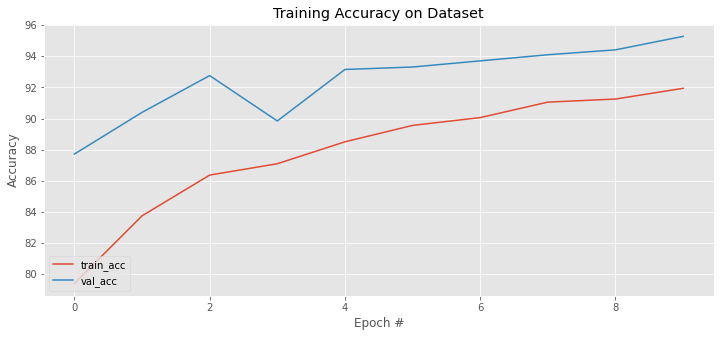

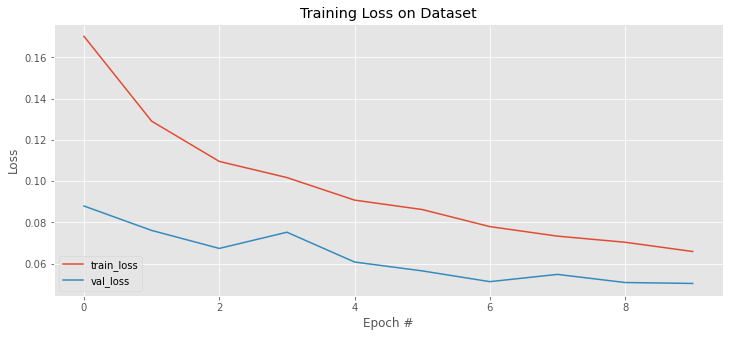

In [17]:
plt.style.use("ggplot")

plt.figure(figsize = (12,5))
plt.plot(TRAIN_STAT["train_acc"], label="train_acc")
plt.plot(TRAIN_STAT["val_acc"], label="val_acc")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

plt.savefig('accuracy.png')

plt.figure(figsize = (12,5))
plt.plot(TRAIN_STAT["train_loss"], label="train_loss")
plt.plot(TRAIN_STAT["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

plt.savefig('loss.png')

### Save the model

In [18]:
model_scripted = torch.jit.script(model_ft) # Export to TorchScript
model_scripted.save('alexnet_sports_non_sports_multilabel.pt') # Save

### Test model

In [19]:
print("Testing model...\n-----------------------------")
with torch.no_grad():
    
    model_ft.eval()
    
    predictions = []
    actual = []
    test_correct = 0
    
    for i, data in enumerate(test_loader):
        # make predictions and add to list of predictions
        inputs, labels = data[0].to(device), data[1]
        main_label = labels["main_label"]
        outputs = model_ft(inputs)
        output_main_label = outputs["main_label"]
        predictions.extend(output_main_label.argmax(axis=1).cpu().numpy())
        actual.extend(main_label.cpu().numpy())
        
# print the results of the predictions in the form of a confusion matrix
print(classification_report(np.array(predictions), np.array(actual), target_names=labels_map))

Testing model...
-----------------------------
              precision    recall  f1-score   support

  Non Sports       0.92      0.94      0.93       540
      Sports       0.96      0.94      0.95       730

    accuracy                           0.94      1270
   macro avg       0.94      0.94      0.94      1270
weighted avg       0.94      0.94      0.94      1270



In [20]:
print("Testing model on sub-category...\n-----------------------------")
with torch.no_grad():
    
    model_ft.eval()
    
    predictions = []
    actual = []
    test_correct = 0
    
    for i, data in enumerate(test_loader):
        # make predictions and add to list of predictions
        inputs, labels = data[0].to(device), data[1]
        main_label = labels["sub_label"]
        outputs = model_ft(inputs)
        output_main_label = outputs["sub_label"]
        predictions.extend(output_main_label.argmax(axis=1).cpu().numpy())
        actual.extend(main_label.cpu().numpy())
        
# print the results of the predictions in the form of a confusion matrix
print(classification_report(np.array(predictions), np.array(actual), target_names=both_combined))

Testing model on sub-category...
-----------------------------
                                         precision    recall  f1-score   support

                            Cello (265)       0.70      0.95      0.81        20
                               Dab (90)       0.44      0.57      0.50         7
       Dog chasing ball (330) ambiguous       0.94      1.00      0.97        31
                          Driving (245)       0.80      0.87      0.83        23
                           Guitar (285)       0.57      0.80      0.67        20
                             Harp (225)       0.96      0.69      0.80        32
           Holding ball (265) ambiguous       0.85      0.76      0.80        29
      Holding something (245) ambiguous       0.52      0.65      0.58        20
                Jumping (270) ambiguous       0.70      0.79      0.75        24
             Leisure sea activity (320)       0.91      0.88      0.89        33
                       Pedestrian (260)      

In [21]:
# prepare to count predictions for each class
correct_pred = [0 for classname in labels_map]
total_pred = [0 for classname in labels_map]

total_correct = 0

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.cuda()
        main_label = labels["main_label"]
        outputs = model_ft(images)
        _, predictions = torch.max(outputs["main_label"], 1)
        # collect the correct predictions for each class
        for label, prediction in zip(main_label, predictions):
            if label == prediction:
                correct_pred[label.item()] += 1
                total_correct += 1
            total_pred[label.item()] += 1


# print accuracy for each class
for classname in range(len(correct_pred)):
    accuracy = 100 * float(correct_pred[classname]) / total_pred[classname]
    total_accuracy = 100 * float(total_correct) / len(test_data)
    print(f'Accuracy for class {labels_map[classname]} is {accuracy:.2f}%')
print(f'Total accuracy: {total_accuracy:.2f}%')

Accuracy for class Non Sports is 92.36%
Accuracy for class Sports is 95.56%
Total accuracy: 94.17%


In [22]:
correct_pred = [0 for classname in both_combined]
total_pred = [0 for classname in both_combined]


total_correct = 0

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.cuda()
        sub_label = labels["sub_label"]
        outputs = model_ft(images)
        _, predictions = torch.max(outputs["sub_label"], 1)
        # collect the correct predictions for each class
        for label, prediction in zip(sub_label, predictions):
            if label == prediction:
                correct_pred[label.item()] += 1
                total_correct += 1
            total_pred[label.item()] += 1


# print accuracy for each class
for classname in range(len(correct_pred)):
    accuracy = 100 * float(correct_pred[classname]) / total_pred[classname]
    total_accuracy = 100 * float(total_correct) / len(test_data)
    print(f'Accuracy for class {both_combined[classname]} is {accuracy:.2f}%')
print(f'Total accuracy: {total_accuracy:.2f}%')

Accuracy for class Cello (265) is 70.37%
Accuracy for class Dab (90) is 44.44%
Accuracy for class Dog chasing ball (330) ambiguous is 93.94%
Accuracy for class Driving (245) is 80.00%
Accuracy for class Guitar (285) is 57.14%
Accuracy for class Harp (225) is 95.65%
Accuracy for class Holding ball (265) ambiguous is 84.62%
Accuracy for class Holding something (245) ambiguous is 52.00%
Accuracy for class Jumping (270) ambiguous is 70.37%
Accuracy for class Leisure sea activity (320) is 90.62%
Accuracy for class Pedestrian (260) is 84.62%
Accuracy for class Plane flying (265) is 88.46%
Accuracy for class Queue (240) is 83.33%
Accuracy for class Random pic with sky view (60) is 50.00%
Accuracy for class Reading (195) is 68.42%
Accuracy for class Riding motorcycle (110) is 90.91%
Accuracy for class Ship with sea (235) is 95.65%
Accuracy for class Sleeping (400) is 97.50%
Accuracy for class Standing (300) is 96.67%
Accuracy for class Standing beside bicycle (250) ambiguous is 72.00%
Accuracy

#### Model intrepretion

In [23]:
from PIL import Image
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = torch.jit.load('alexnet_sports_non_sports_multilabel.pt')
model.cpu()
model.eval()

RecursiveScriptModule(
  original_name=MultiOutputModel
  (base_model): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=MaxPool2d)
    (3): RecursiveScriptModule(original_name=Conv2d)
    (4): RecursiveScriptModule(original_name=ReLU)
    (5): RecursiveScriptModule(original_name=MaxPool2d)
    (6): RecursiveScriptModule(original_name=Conv2d)
    (7): RecursiveScriptModule(original_name=ReLU)
    (8): RecursiveScriptModule(original_name=Conv2d)
    (9): RecursiveScriptModule(original_name=ReLU)
    (10): RecursiveScriptModule(original_name=Conv2d)
    (11): RecursiveScriptModule(original_name=ReLU)
    (12): RecursiveScriptModule(original_name=MaxPool2d)
  )
  (pool): RecursiveScriptModule(original_name=AdaptiveAvgPool2d)
  (main_label): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Dro

In [24]:
transform_resize = transforms.Compose([
    # resize
    transforms.Resize(256),
    # center_crop
    transforms.CenterCrop(224),
    transforms.ToTensor()])
transform_normalize = transforms.Compose([transforms.Normalize([0.4405, 0.4096, 0.3896], [0.3089, 0.2917, 0.2924])])

In [25]:
img = Image.open('dataset/non sport/guitar/Acoustic Lessons.jpg')
resized_img = transform_resize(img)
transformed_img = transform_normalize(resized_img)
input = transformed_img.unsqueeze(0)
# input = input.to(device)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/non sport/guitar/Acoustic Lessons.jpg'

In [ ]:
output = model(input)
main_label_output = F.softmax(output['main_label'], dim=1)
sub_label_output = F.softmax(output['sub_label'], dim=1)

In [ ]:
prediction_score, pred_label_idx = torch.topk(main_label_output, 1)
pred_label_main = labels_map[pred_label_idx.item()]

prediction_score_sub, pred_label_idx_sub = torch.topk(sub_label_output, 1)
pred_label_sub = both_combined[pred_label_idx_sub.item()]
pred_label_sub

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import LayerIntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr._utils.input_layer_wrapper import ModelInputWrapper
from matplotlib.colors import LinearSegmentedColormap

def wrapped_model(inp):
    return model(inp)["main_label"]

def wrapped_model_sub(inp):
    return model(inp)["sub_label"]

# def attribute_image_features(algorithm, input, target, **kwargs):
#     model.zero_grad()
#     tensor_attributions = algorithm.attribute(input,
#                                               target=target,
#                                               **kwargs
#                                              )
    
#     return tensor_attributions

In [ ]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

In [ ]:
integrated_gradients = IntegratedGradients(wrapped_model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(resized_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [ ]:
integrated_gradients = IntegratedGradients(wrapped_model_sub)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx_sub, n_steps=200)

noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=20, nt_type='smoothgrad_sq', target=pred_label_idx_sub)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(resized_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [ ]:
gradient_shap = GradientShap(wrapped_model_sub)
rand_img_dist = torch.cat([input * 0, input * 1])
attributions_gs = gradient_shap.attribute(input,
              n_samples=50,
              stdevs=0.0001,
              baselines=rand_img_dist,
              target=pred_label_idx_sub)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(resized_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [ ]:
occlusion = Occlusion(wrapped_model_sub)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx_sub,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(resized_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

In [ ]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

In [ ]:
def get_classes():
    classes = ['Pedestrian', 'Queue', 'Reading', 'cello',
               'driving', 'guitar', 'harp', 'using computer',
               'violin', 'Badminton', 'Basketball', 'Cycling',
               'Football', 'Tennis', 'squash']
    return classes

def get_classes_main():
    classes = ['Non Sports', 'Sports']
    return classes

def get_pretrained_model():
    model = torch.jit.load('alexnet_sports_non_sports_multilabel.pt')
    model = model.cpu()
    def wrapped_model_sub(inp):
        return model(inp)["main_label"]
    return wrapped_model_sub

In [ ]:
def baseline_func(input):
    return input * 0


def formatted_data_iter():
    dataloader = iter(test_loader)
    while True:
        images, labels = next(dataloader)
        yield Batch(inputs=images, labels=labels["main_label"])

In [ ]:
normalize = transforms.Normalize([0.4405, 0.4096, 0.3896], [0.3089, 0.2917, 0.2924])
model = get_pretrained_model()
visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=get_classes_main(),
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[normalize],
        )
    ],
    dataset=formatted_data_iter(),
)

In [ ]:
visualizer.render()